In [1]:
library('igraph')
library('Matrix')
library('pracma')
library('visNetwork')


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union


Attaching package: 'pracma'

The following objects are masked from 'package:Matrix':

    expm, lu, tril, triu



In [2]:
g<-read_graph('facebook_combined.txt', directed=F)

[1] TRUE

[1] 4039

[1] 8

[1] 43.69101

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"819 y values <= 0 omitted from logarithmic plot"

log(degs_outlier) 
        -1.655832

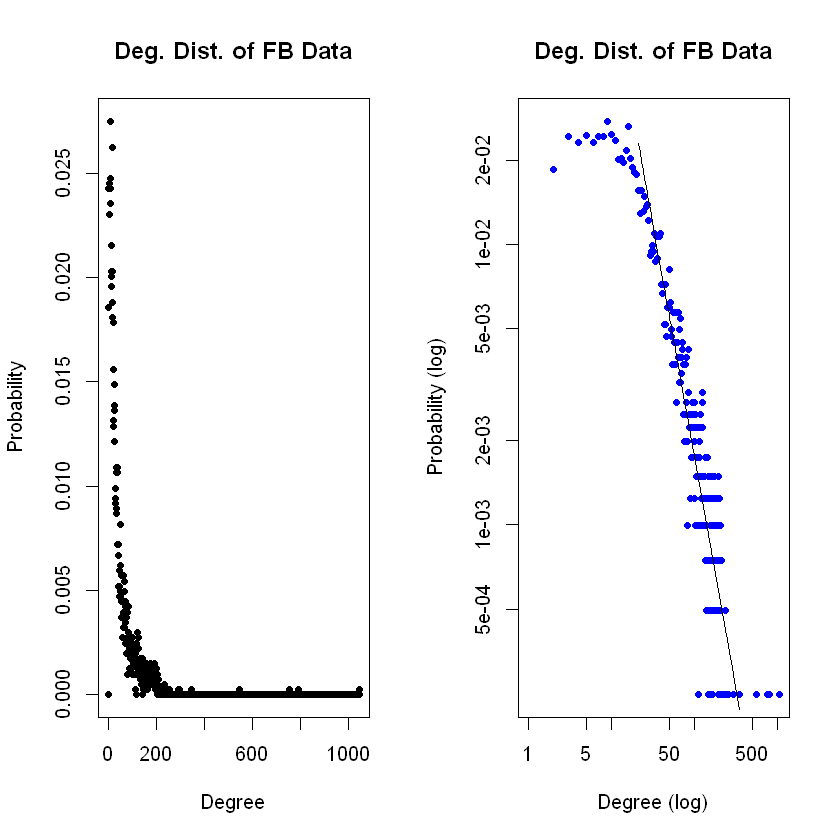

In [77]:
is.connected(g)
vcount(g)
diameter(g)
d<-degree(g)
mean(d)

par(mfrow=c(1,2)) #formatting

dist<-degree.distribution(g)
plot(dist,xlab='Degree',ylab='Probability',main='Deg. Dist. of FB Data',cex=0.8,pch=16)

degs<-which(dist!=0)
degs_outlier<-degs[log(degs)>3 & log(degs)< 6] # removes some outliers for the fit
fit<-lm(log(dist[degs_outlier]) ~ log(degs_outlier))
yfit<-fit$fitted.values
plot(dist,log='xy',xlab='Degree (log)',ylab='Probability (log)',main='Deg. Dist. of FB Data',cex=0.8,pch=16,col='blue')
lines(degs_outlier, exp(yfit))
degs<-seq(1,length(dist))

fit$coefficients[2] # contains the slope

To answer the questions: 
1. The Facebook graph is connected. As such, the GCC is the whole graph, which contains all 4039 nodes in it. 
2. The diameter of the network is 8. 
3. The average degree of the network is 43.7. 
4. Here, the slope of the log-log plot for the degree distribution is approximately -1.66, which means that the power coefficient is not in the range where the distribution is heavy-tailed. 

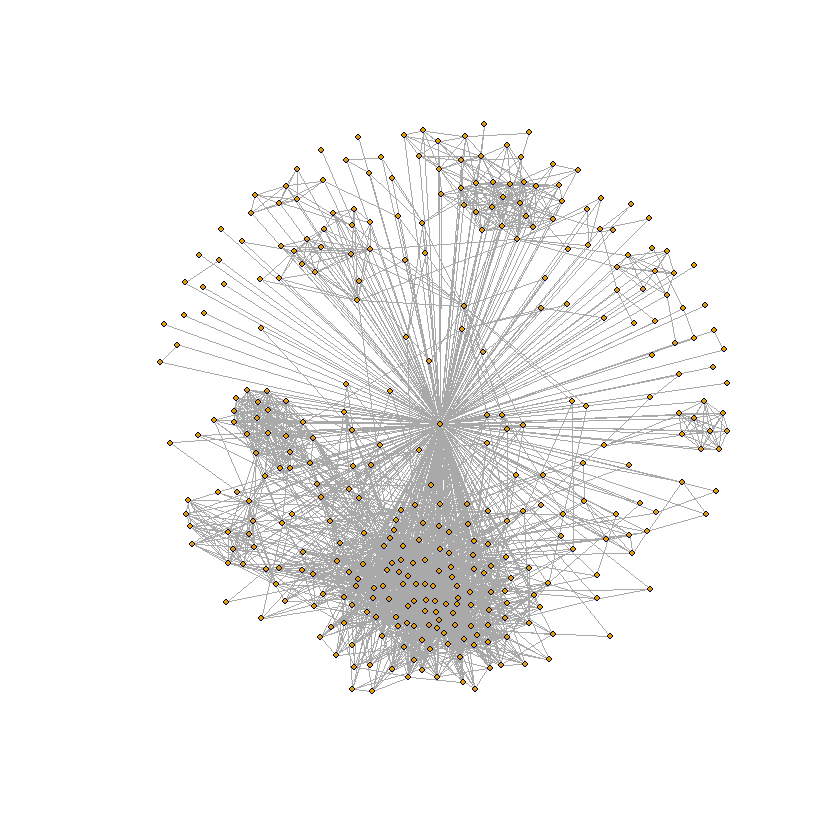

In [100]:
n <- 1 # node we are interested in. 
m <- seq(1,vcount(g))
m <- m[!(m == n |m %in% neighbors(g,n))] # gets all vertices that are not in the network. 
V(g)$vid <- seq(1,vcount(g))
g1 <- delete.vertices(g, m)
plot(g1, vertex.label=V(g1)$vid, vertex.size=2,vertex.label.cex=0.1)

In [102]:
vcount(g1)
ecount(g1)
diameter(g1)

[1] 348

[1] 2866

[1] 2

5. Here, there are 348 nodes and 2866 edges. 
6. The diameter of the network is 2. The minimum for the diameter of the network is 1. The maximum for the diameter is 2. 
7. This is because there will always be a path of length 2 between any two nodes - through the center of the personal network and to any other node. The only case where the diameter of the network is 1 is if the network is completely connected (I think?)

In [103]:
# 1.3
g.degs<-degree(g)
core.degs<-g.degs[g.degs>200]
n_core=length(core.degs)
mean_core=mean(core.degs)
n_core
mean_core

[1] 40

[1] 279.375

8. There are 40 core nodes in this graph, with an average degree of 279.4. 

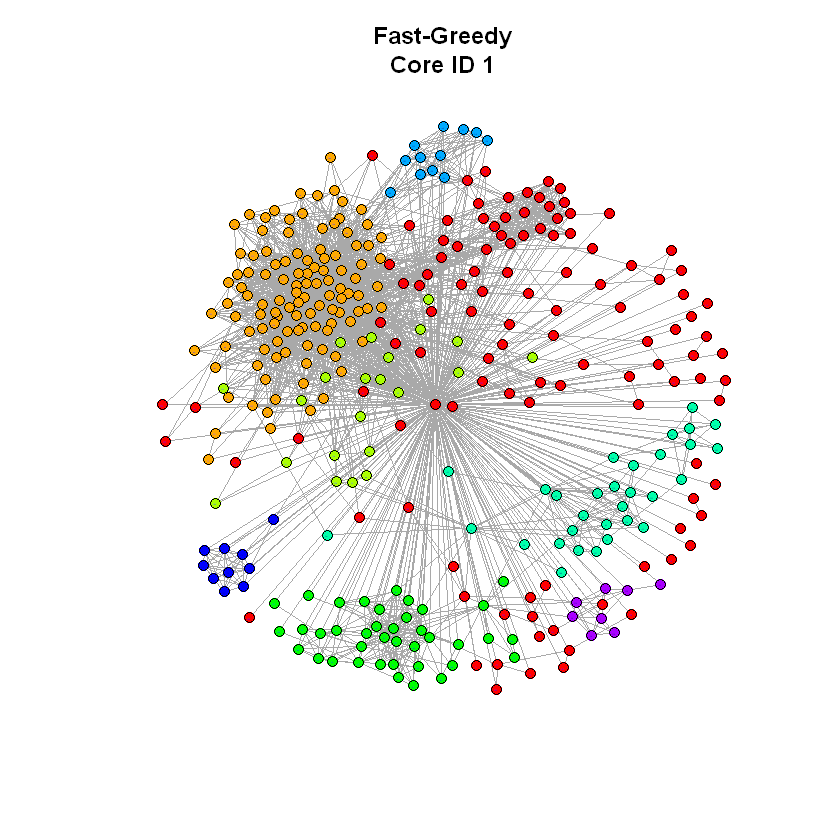

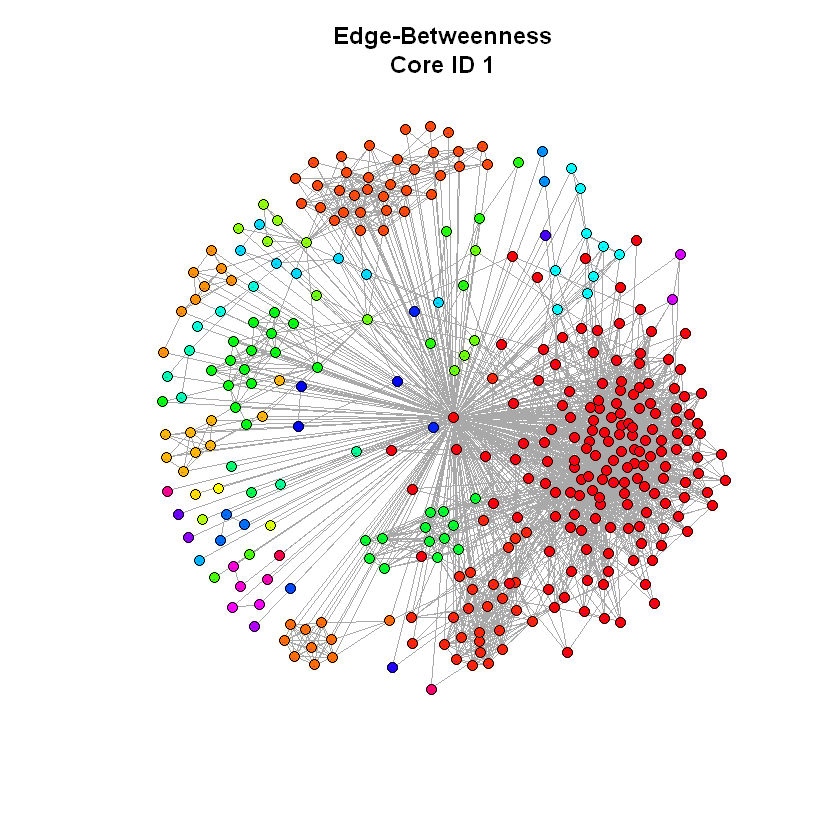

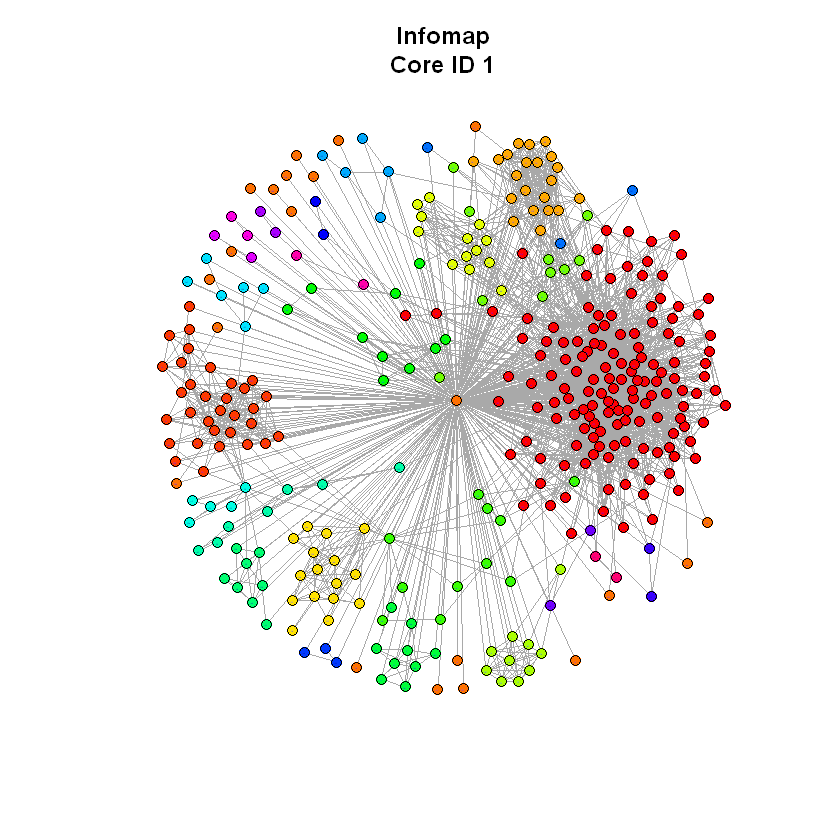

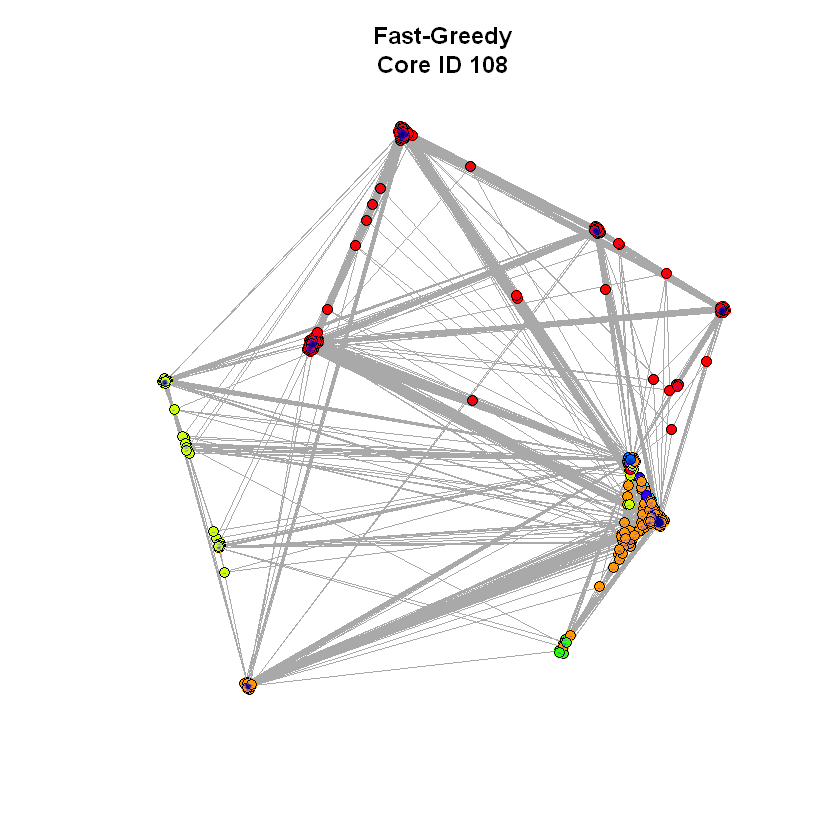

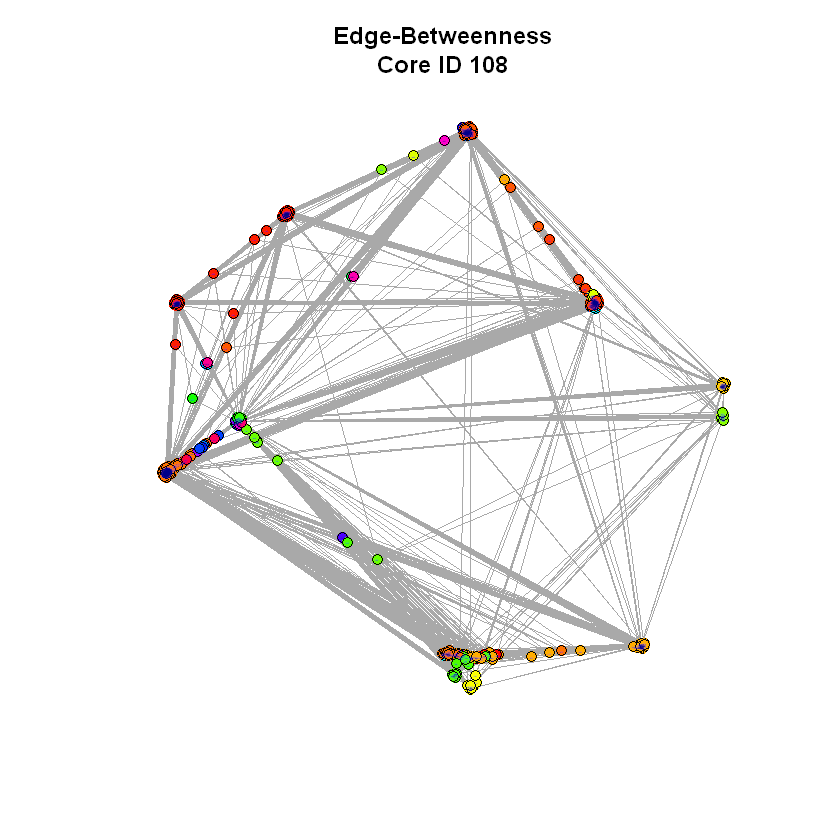

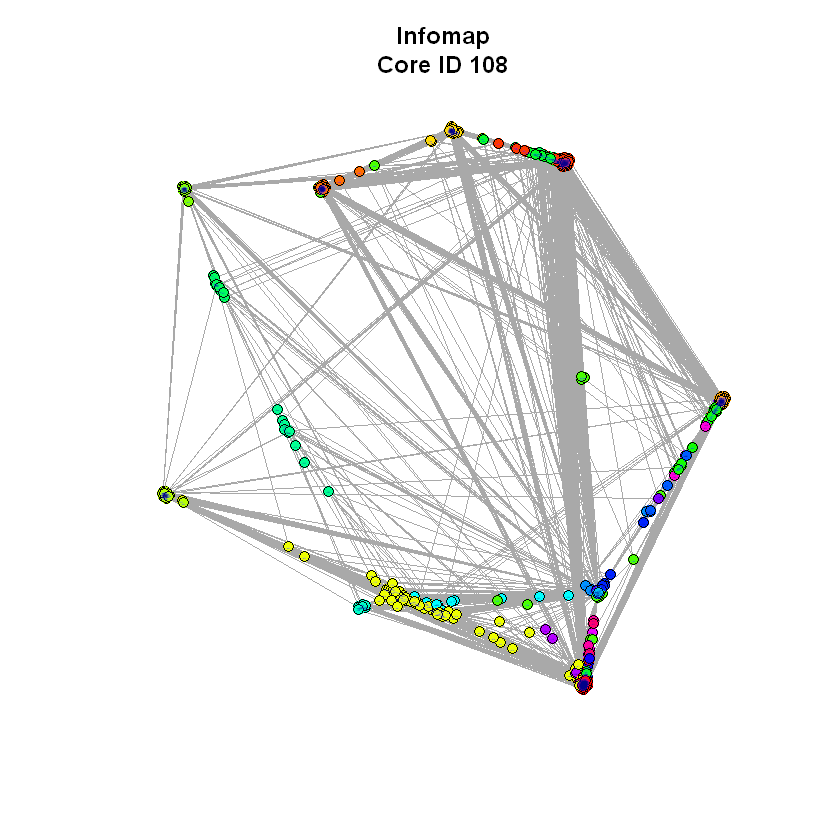

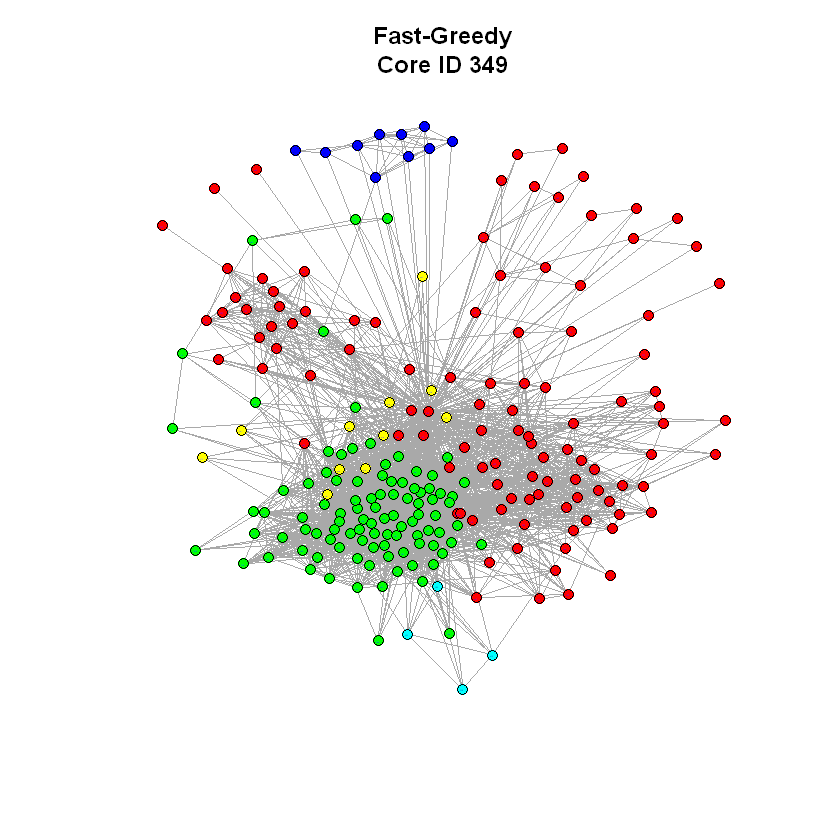

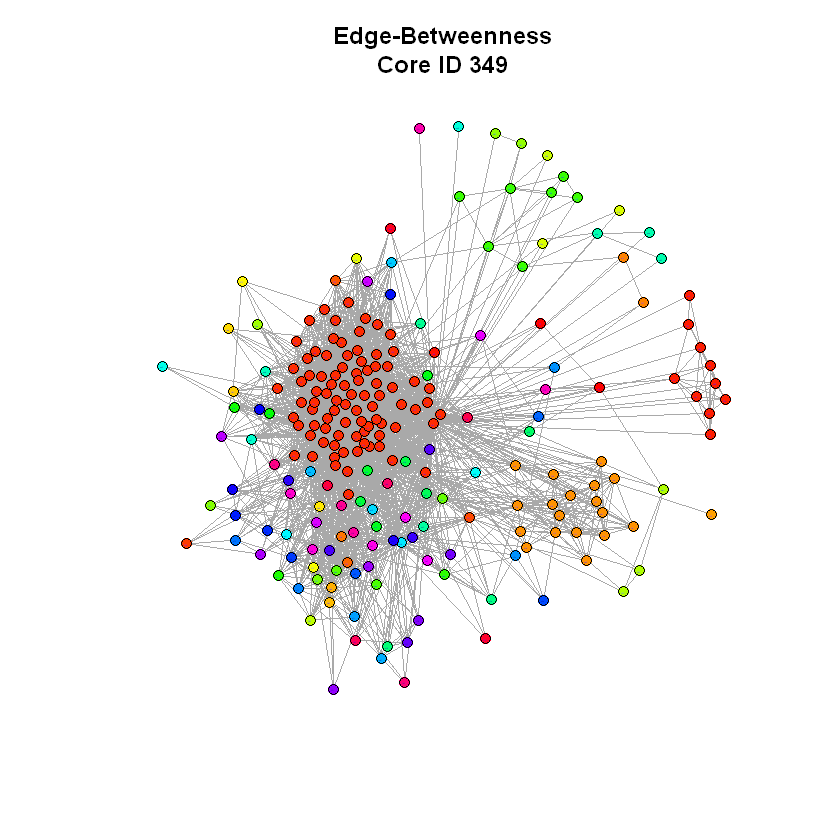

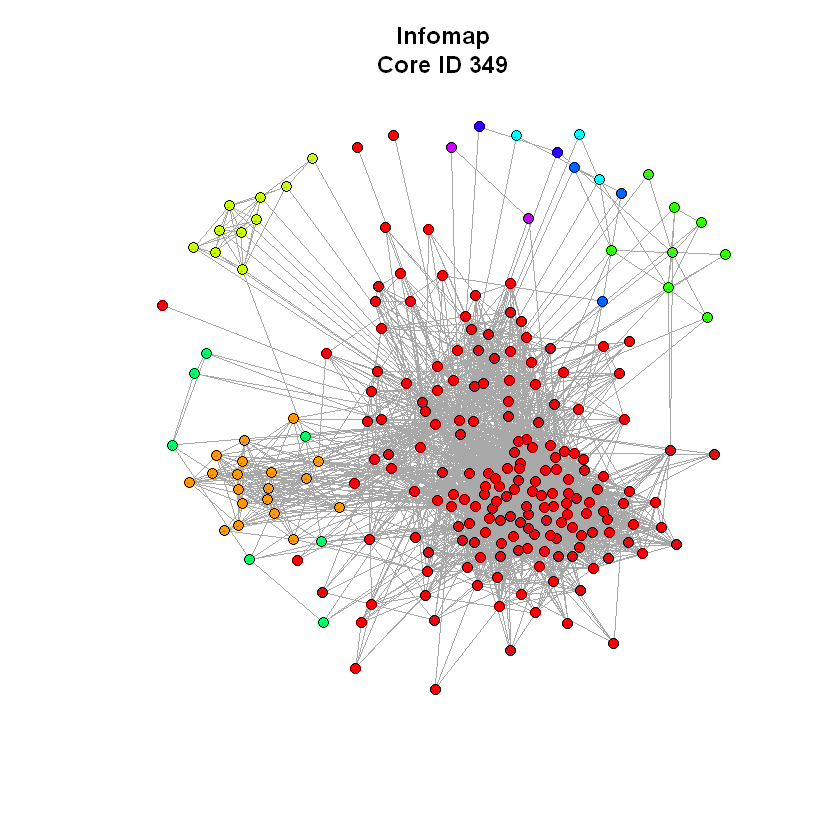

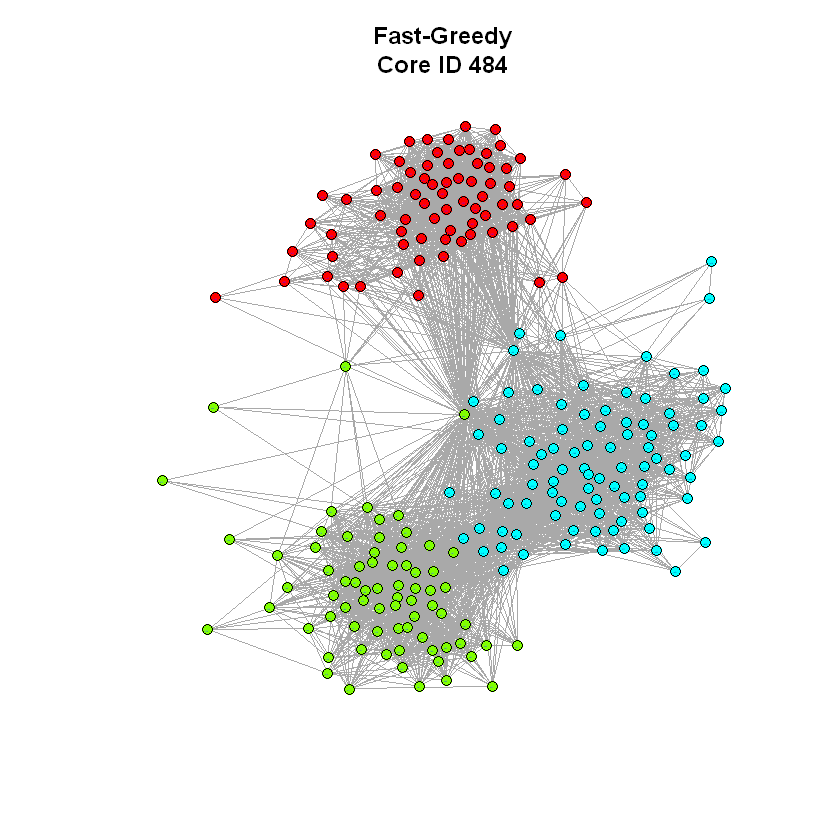

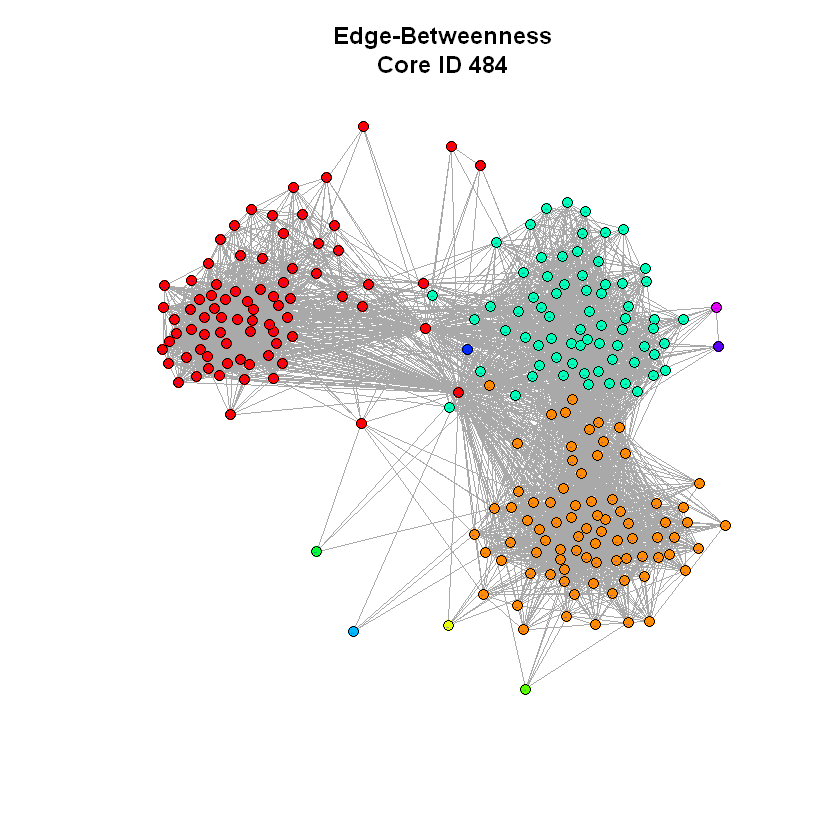

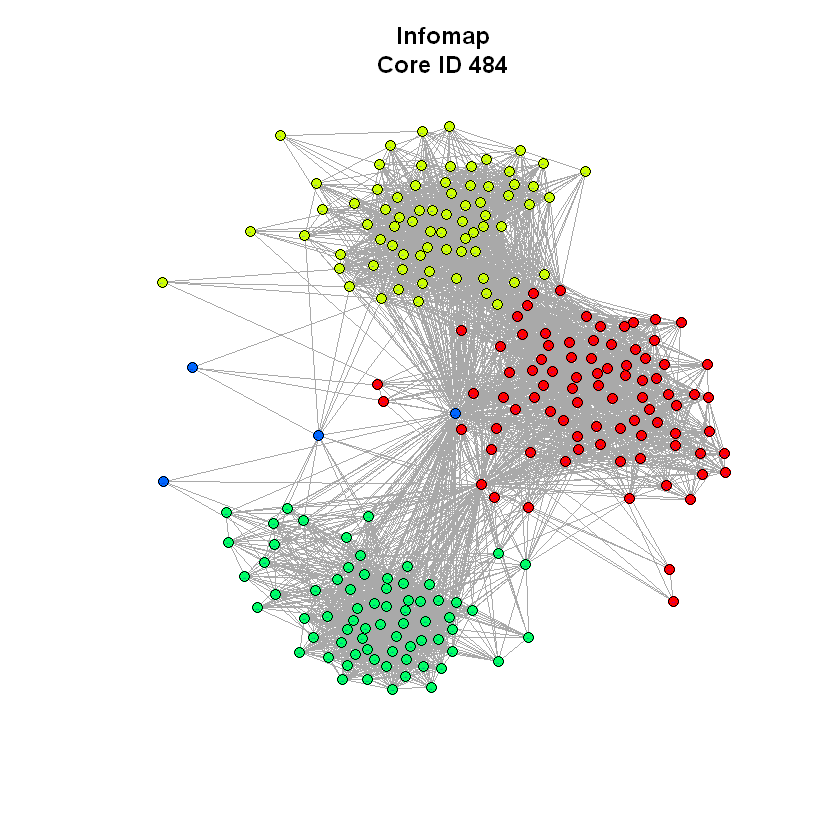

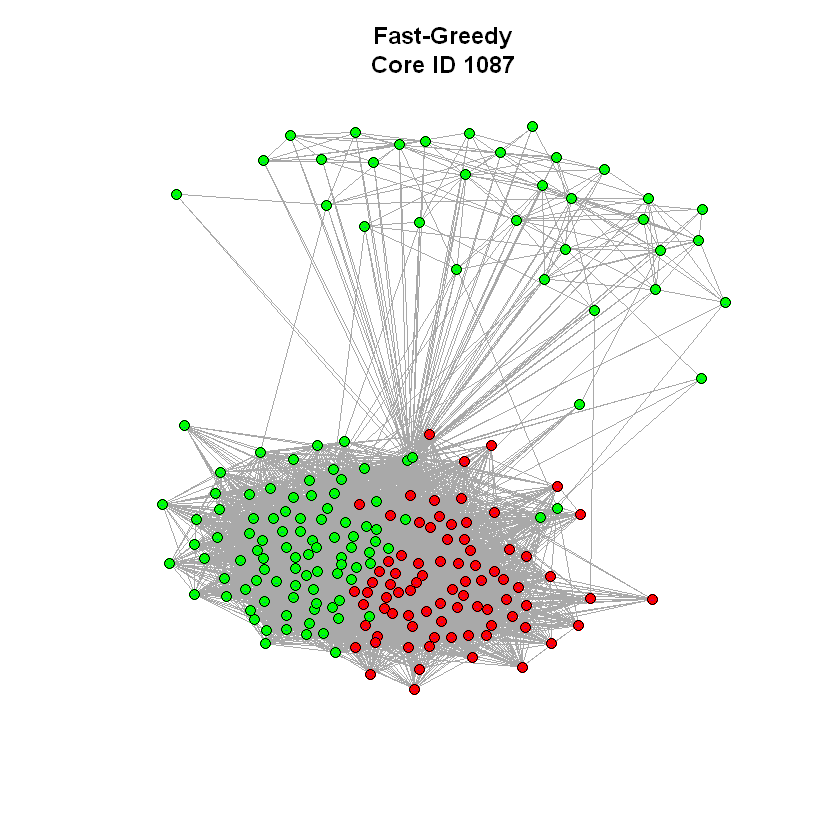

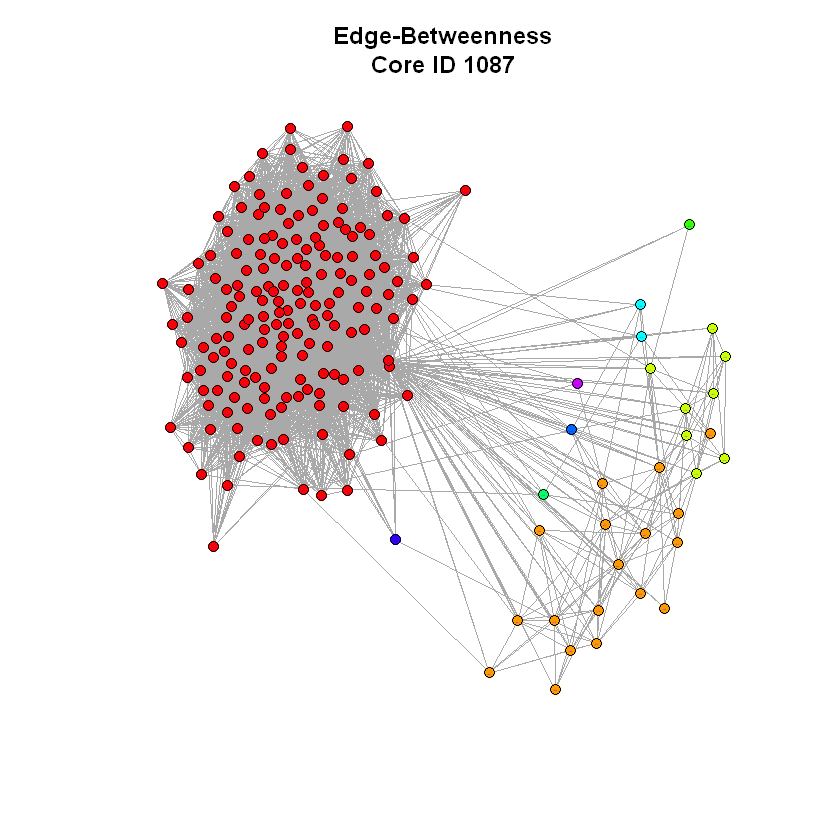

Core.ID.Node,Fast.Greedy.Modularity,Edge.Betweenness.Modularity,Infomap.Modularity
1,0.4131014,0.35330217,0.38911847
108,0.4359294,0.50675492,0.50822334
349,0.2517149,0.13352802,0.09546420
484,0.5070016,0.48909518,0.51527875
1087,0.1455315,0.02762377,0.02690662


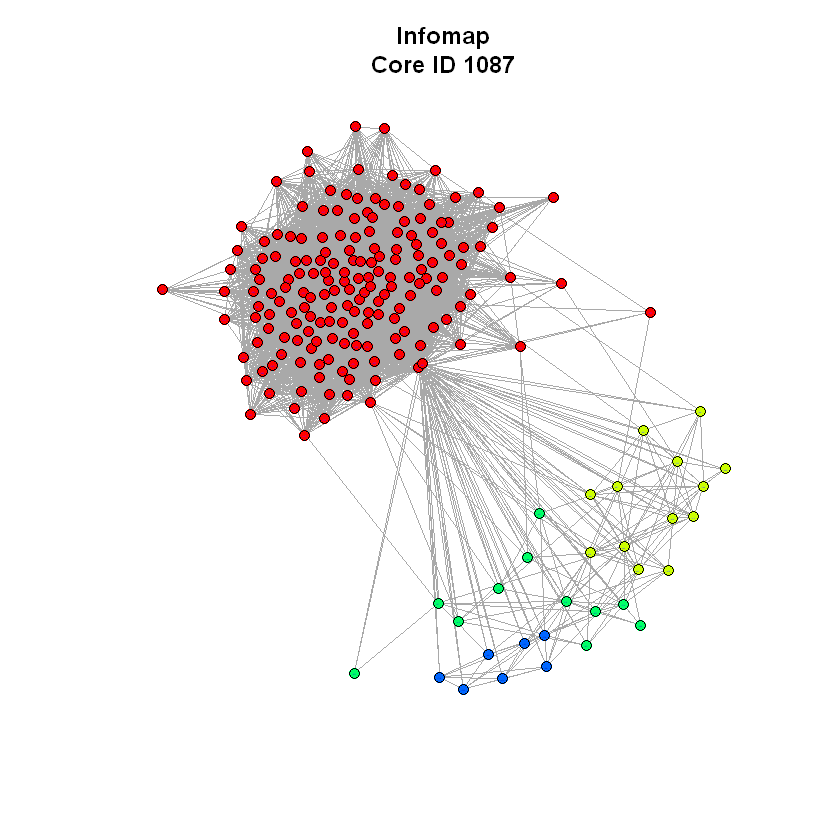

In [105]:
# 1.3.1
core_ids=c(1,108,349,484,1087)
fg.mods=numeric(5)
eb.mods=numeric(5)
im.mods=numeric(5)
for (n in core_ids){
    m <- seq(1,vcount(g))
    m <- m[!(m == n |m %in% neighbors(g,n))] #not connected to n
    g1 <- delete.vertices(g, m)
    
    fg<-cluster_fast_greedy(g1)
    fg.mods[match(n,core_ids)]=max(fg$mod)
    colors = rainbow(size(groups(fg))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(fg)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Fast-Greedy","\n", "Core ID ",n,sep=""))
    
    eb<-cluster_edge_betweenness(g1)
    eb.mods[match(n,core_ids)]=max(eb$mod)
    colors = rainbow(size(groups(eb))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(eb)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Edge-Betweenness","\n", "Core ID ",n,sep=""))
    
    im<-cluster_infomap(g1)
    im.mods[match(n,core_ids)]=max(im$mod)
    colors = rainbow(size(groups(im))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(im)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Infomap","\n", "Core ID ",n,sep=""))
}
data.frame("Core ID Node"=core_ids,"Fast-Greedy Modularity"=fg.mods,"Edge-Betweenness Modularity"=eb.mods,"Infomap Modularity"=im.mods)

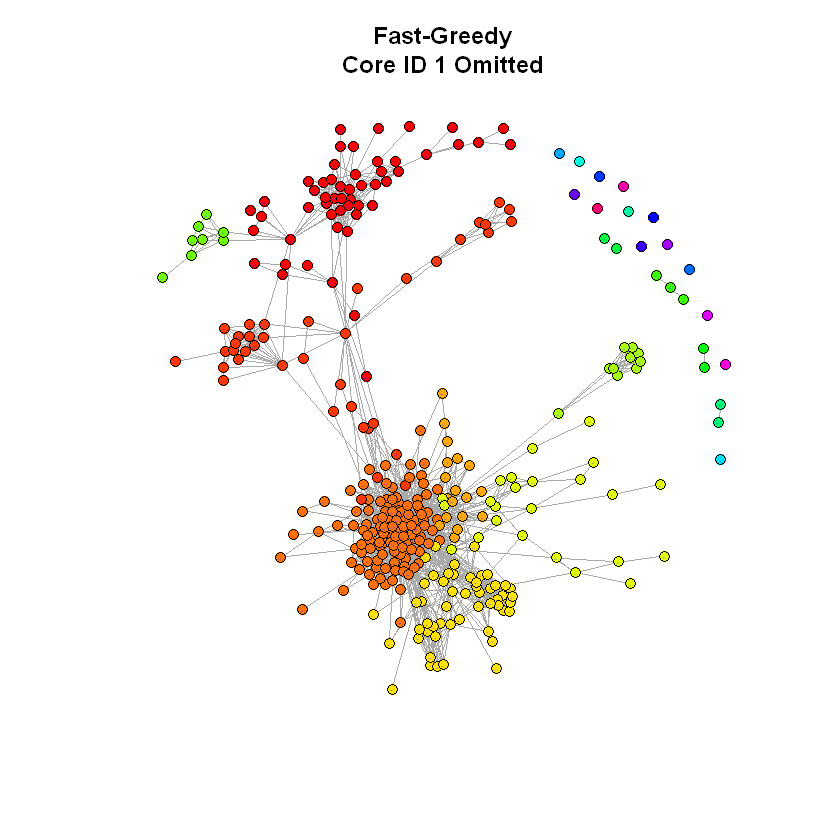

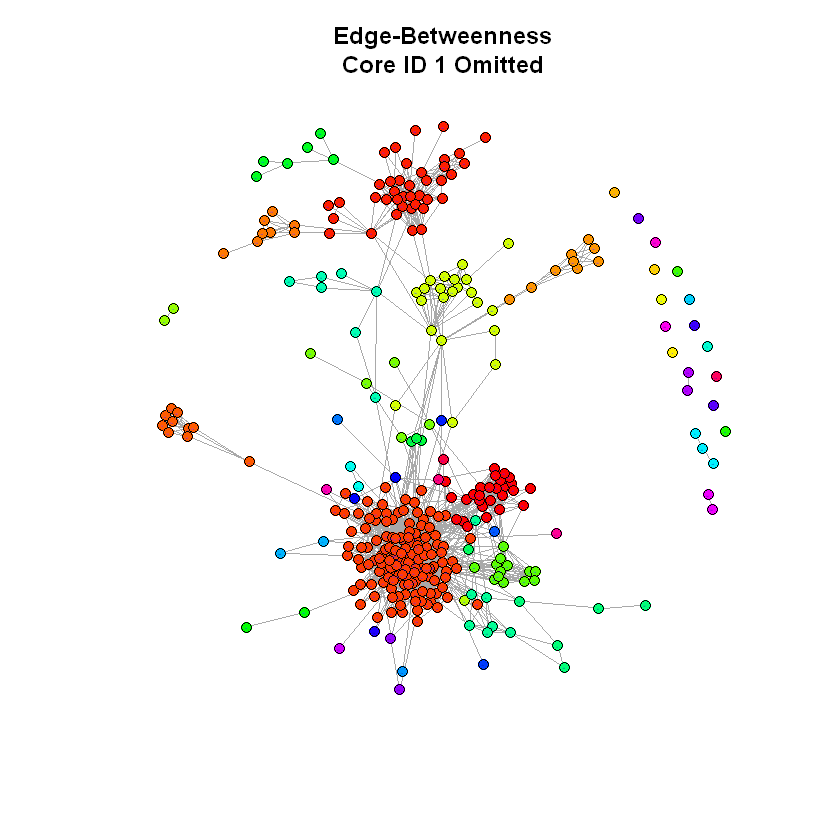

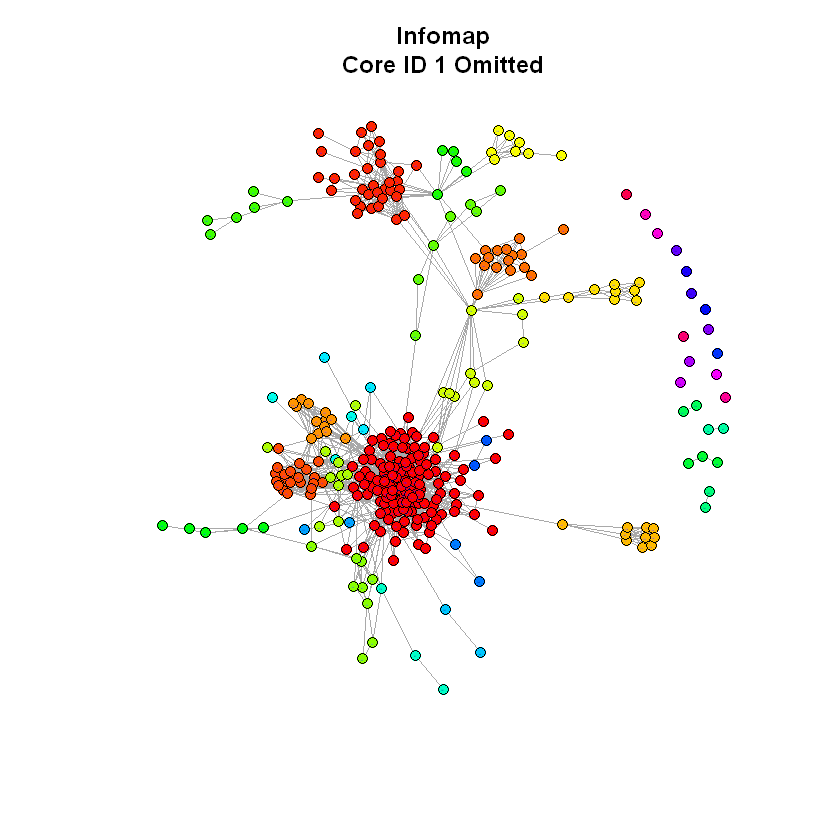

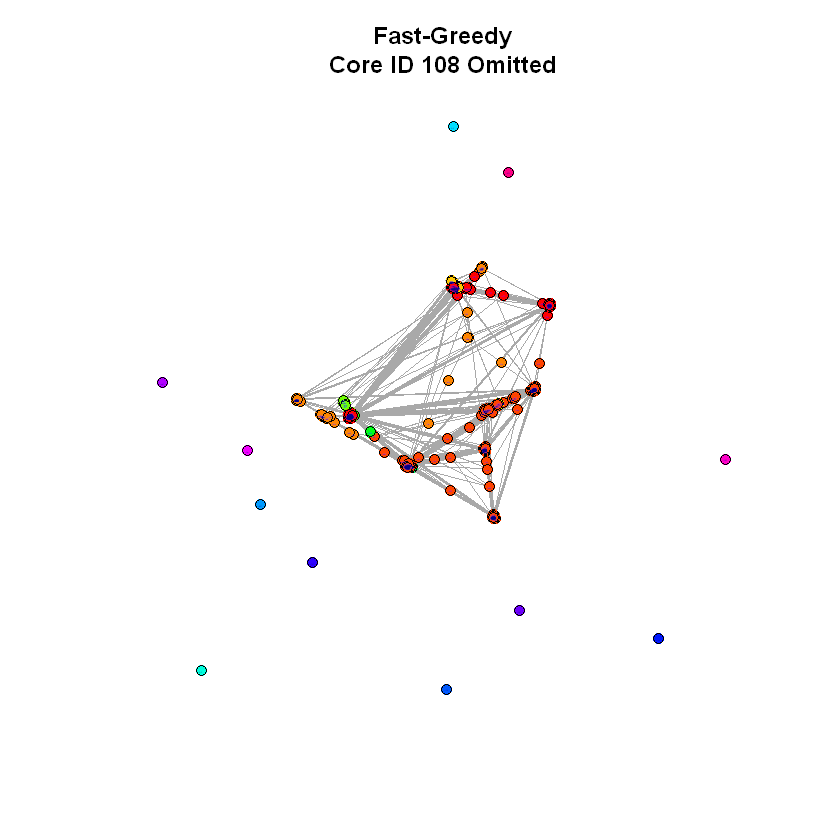

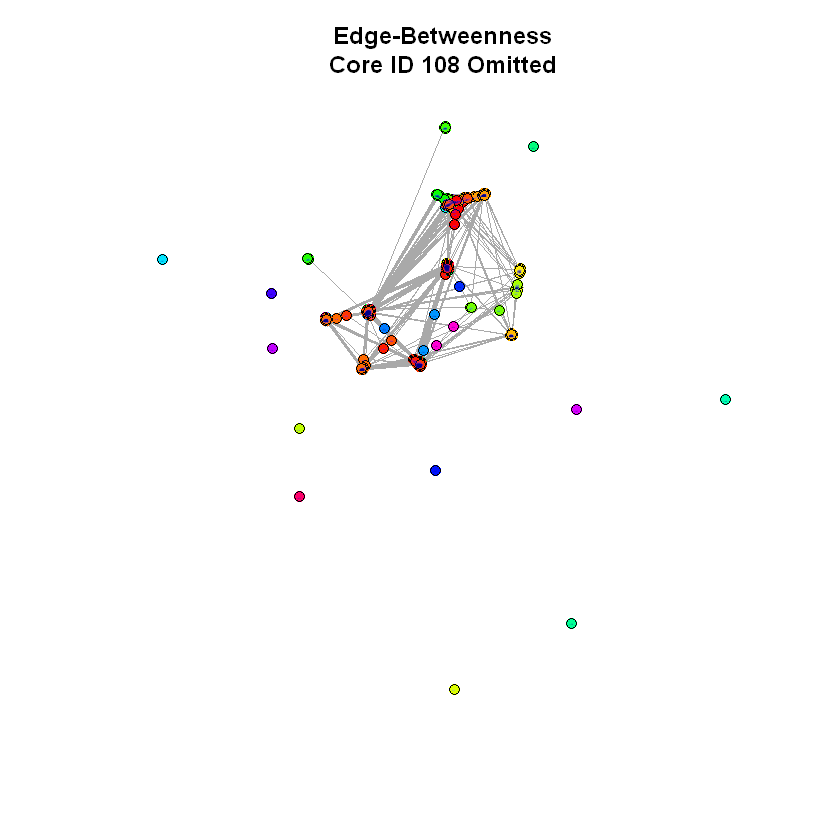

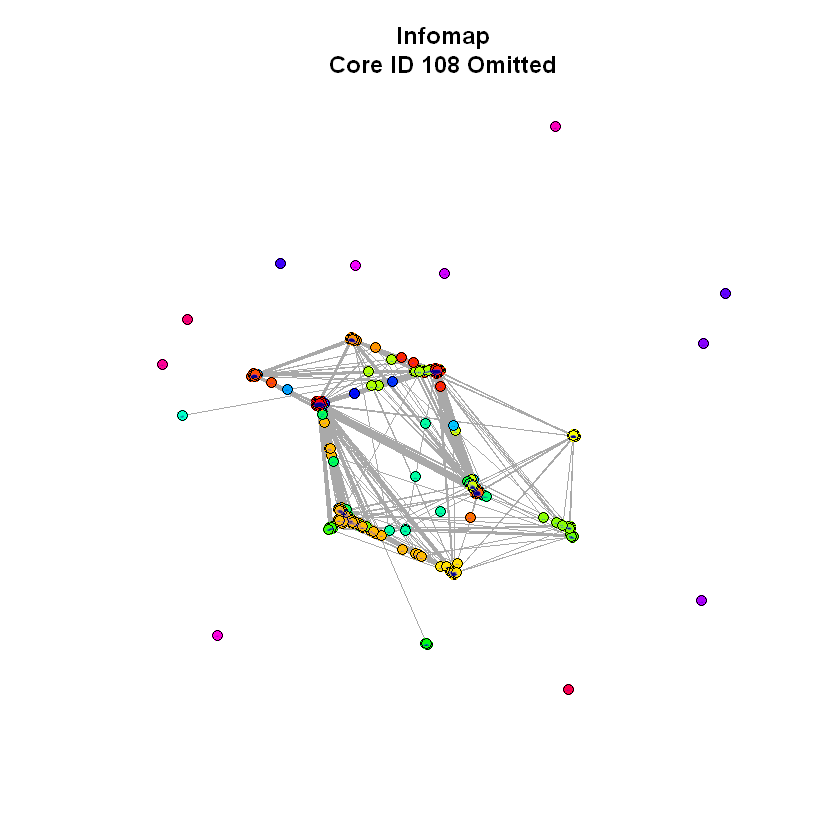

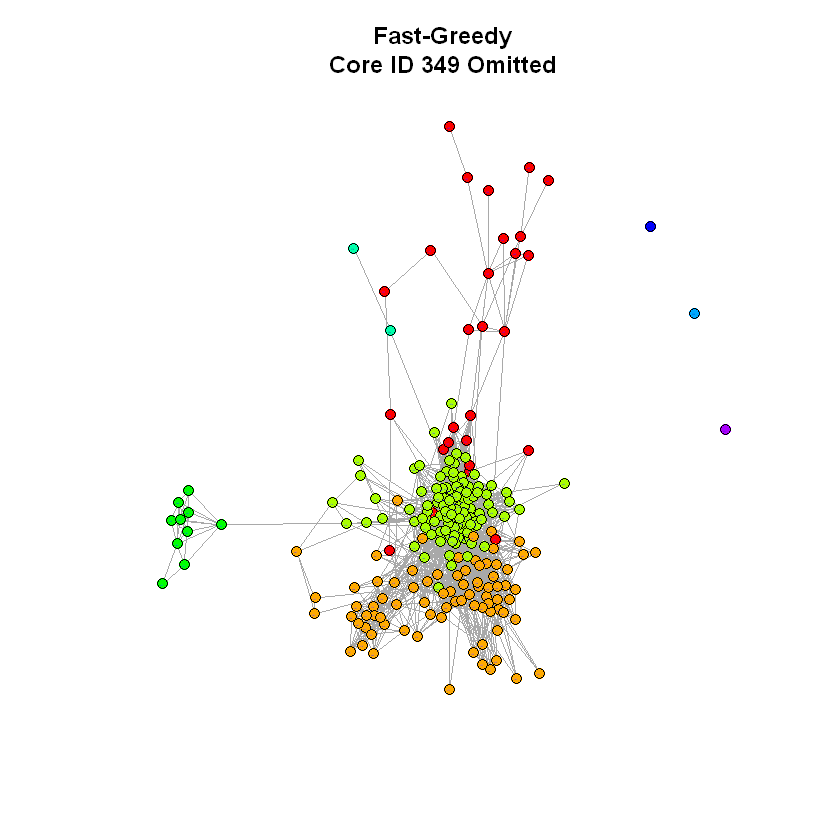

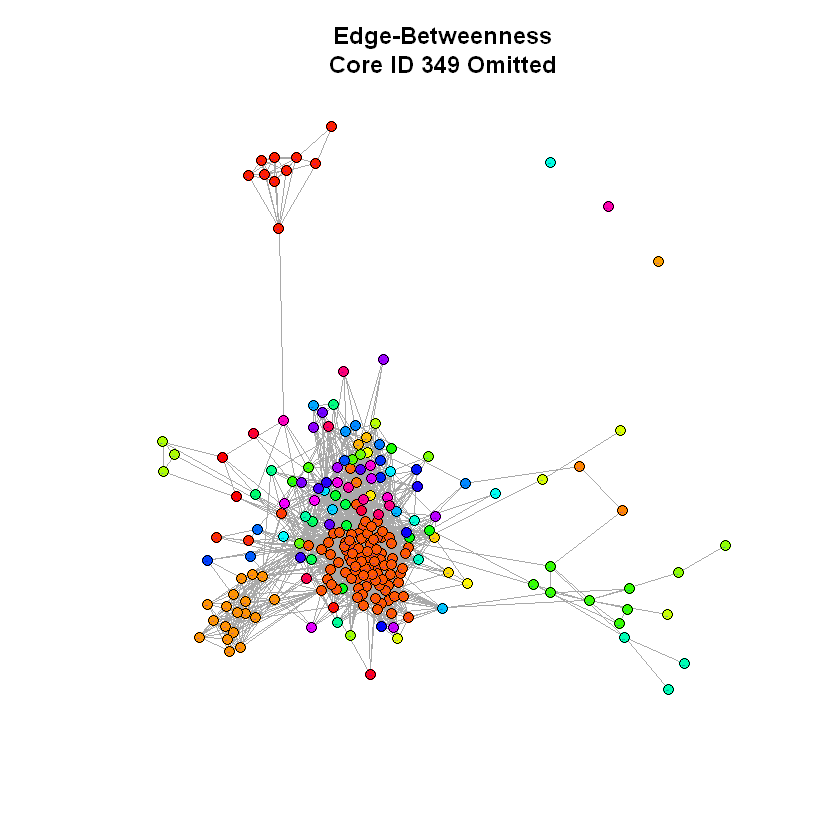

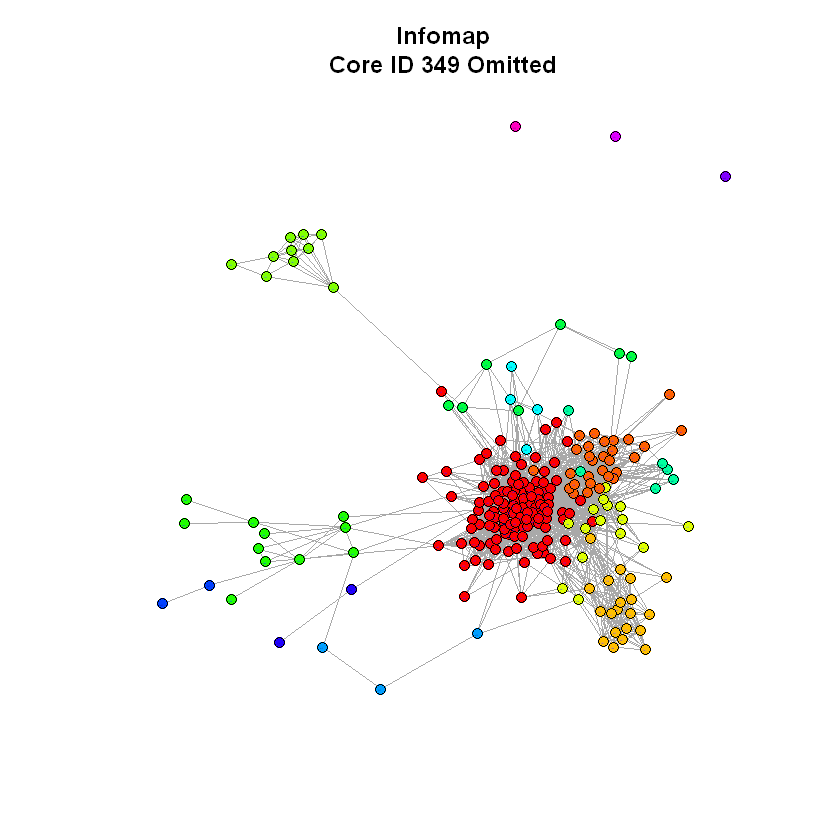

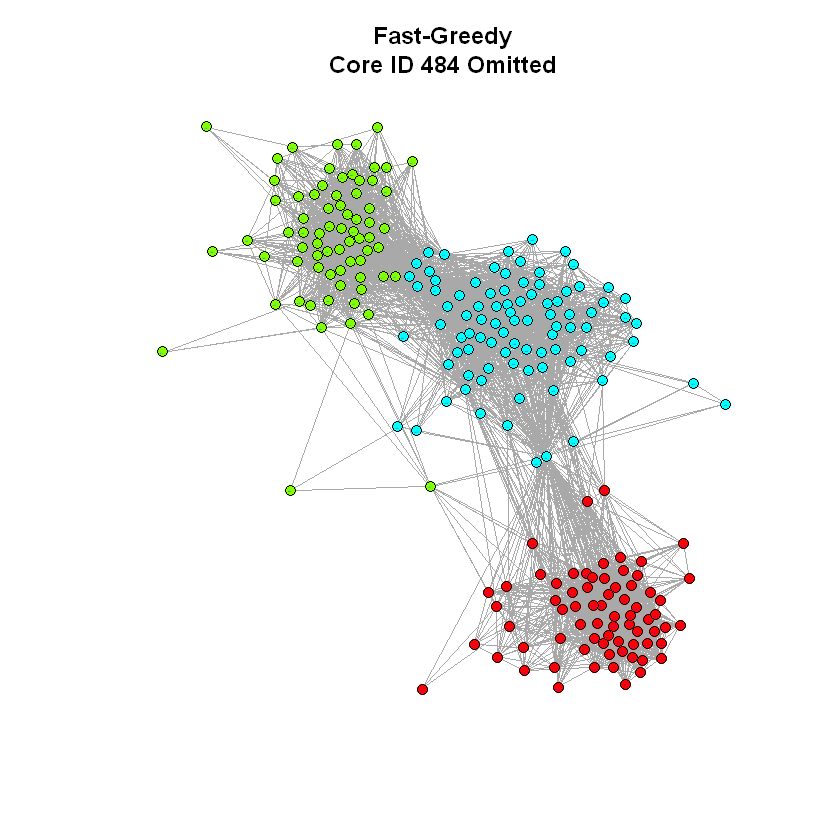

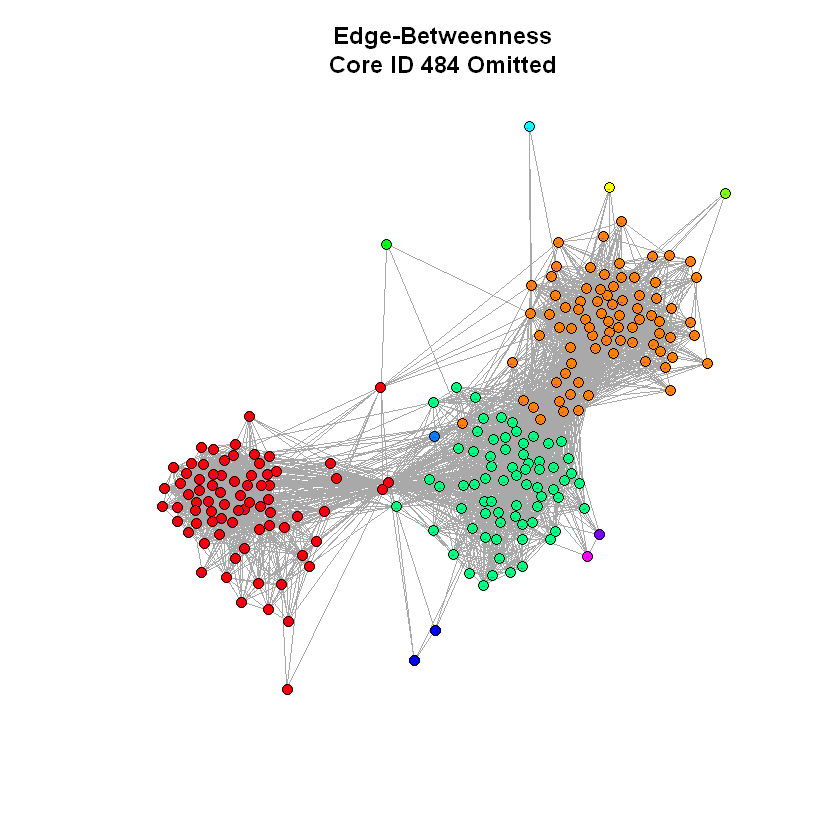

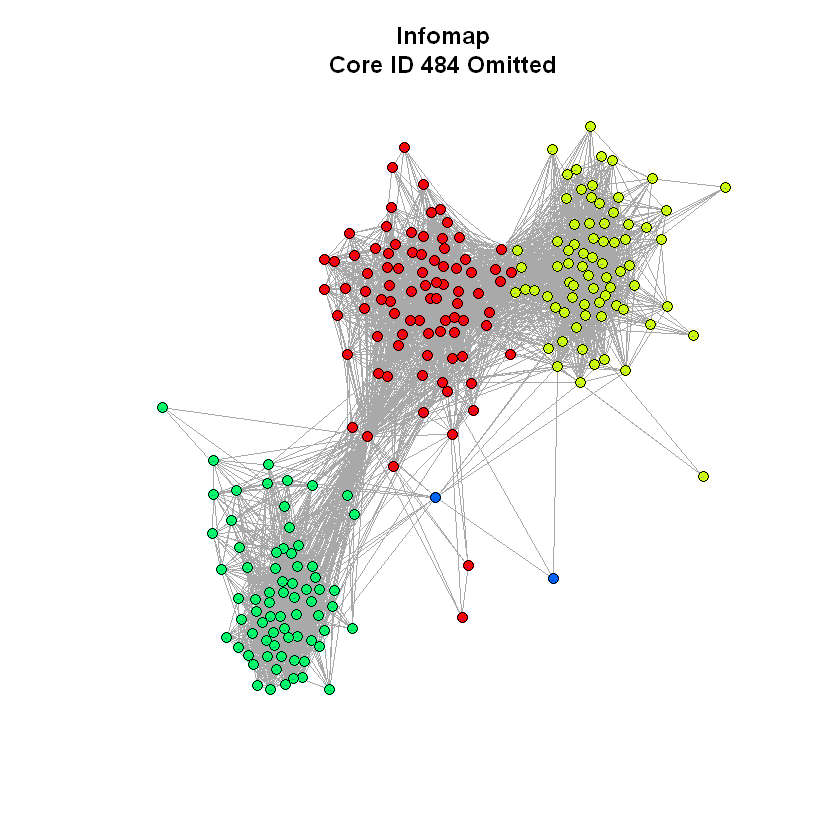

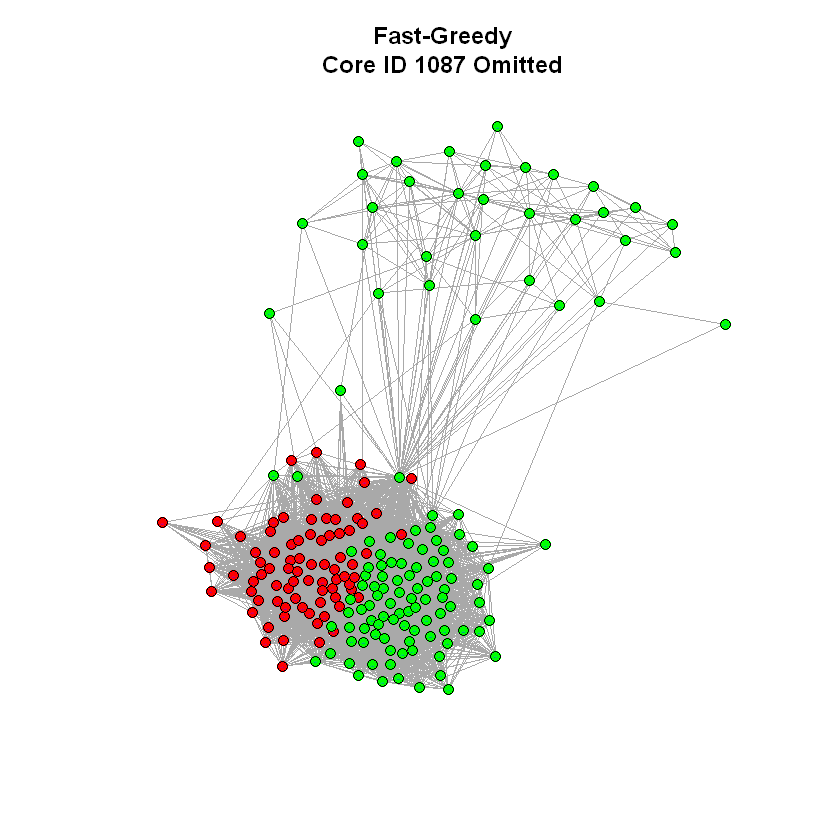

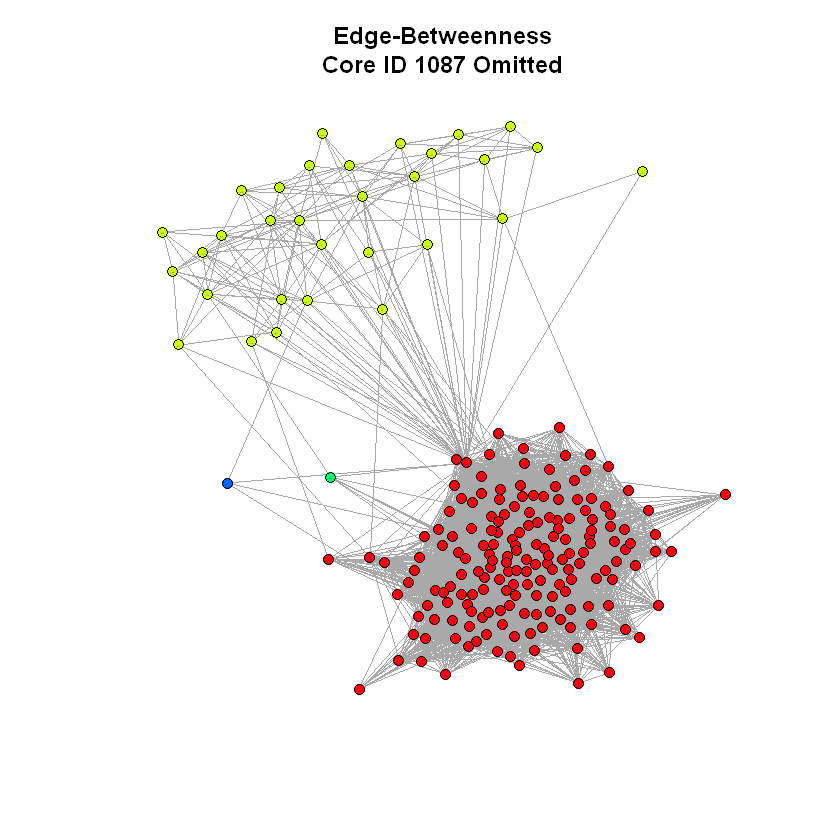

Core.ID.Node,Fast.Greedy.Modularity,Edge.Betweenness.Modularity,Infomap.Modularity
1,0.4418533,0.4161461,0.41800766
108,0.4581271,0.5213216,0.52051712
349,0.2456918,0.1505663,0.24481562
484,0.5342142,0.5154413,0.54344368
1087,0.1481956,0.0324953,0.02777604


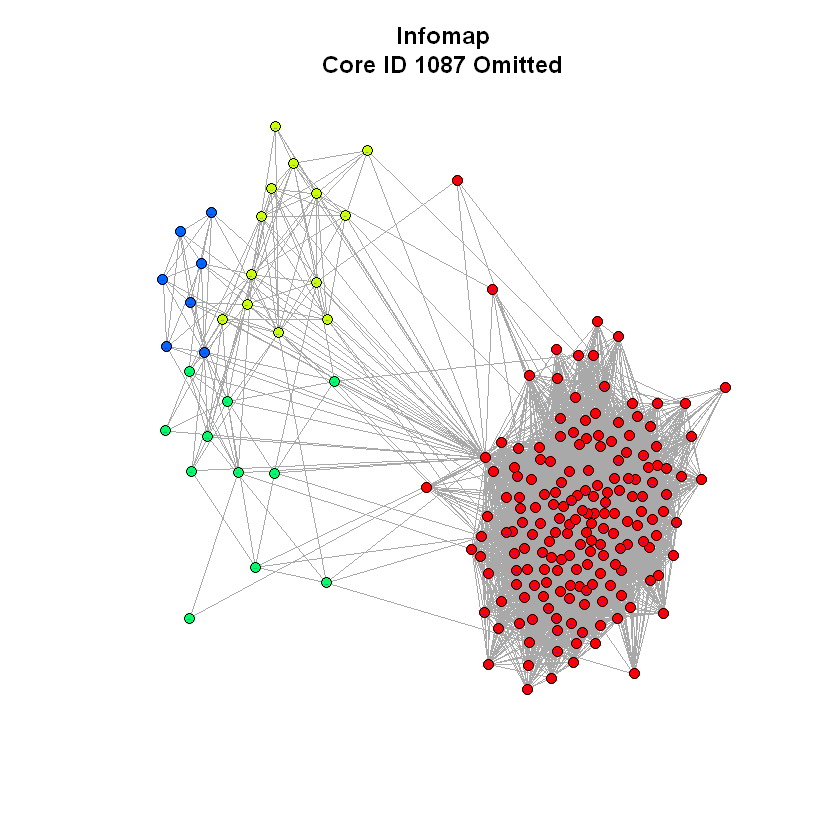

In [106]:
# 1.3.2, now omitting core nodes from their personalized networks
core_ids=c(1,108,349,484,1087)
fg.mods=numeric(5)
eb.mods=numeric(5)
im.mods=numeric(5)
for (n in core_ids){
    m <- seq(1,vcount(g))
    m <- m[!(m %in% neighbors(g,n))] #not connected to n
    g1 <- delete.vertices(g, m)
    
    fg<-cluster_fast_greedy(g1)
    fg.mods[match(n,core_ids)]=max(fg$mod)
    colors = rainbow(size(groups(fg))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(fg)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Fast-Greedy","\n", "Core ID ",n," Omitted",sep=""))
    
    eb<-cluster_edge_betweenness(g1)
    eb.mods[match(n,core_ids)]=max(eb$mod)
    colors = rainbow(size(groups(eb))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(eb)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Edge-Betweenness","\n", "Core ID ",n," Omitted",sep=""))
    
    im<-cluster_infomap(g1)
    im.mods[match(n,core_ids)]=max(im$mod)
    colors = rainbow(size(groups(im))+1)
    nodes_colors = colors[1:(length(colors)-1)]
    V(g1)$color = nodes_colors[membership(im)]
    plot(g1,vertex.label=V(g1)$vid, vertex.size=4,vertex.label.cex=0.1,main=paste("Infomap","\n", "Core ID ",n," Omitted",sep=""))
}
data.frame("Core ID Node"=core_ids,"Fast-Greedy Modularity"=fg.mods,"Edge-Betweenness Modularity"=eb.mods,"Infomap Modularity"=im.mods)

In [3]:
create_personalized_network = function (n, g, add_core=T){
    m = seq(1,vcount(g))
    included = m %in% neighbors(g,n)
    if (add_core)
        included = included | (m == n)
    m = m[!included]
    
    p_network = delete.vertices(g, m)
    
    return(p_network)
}

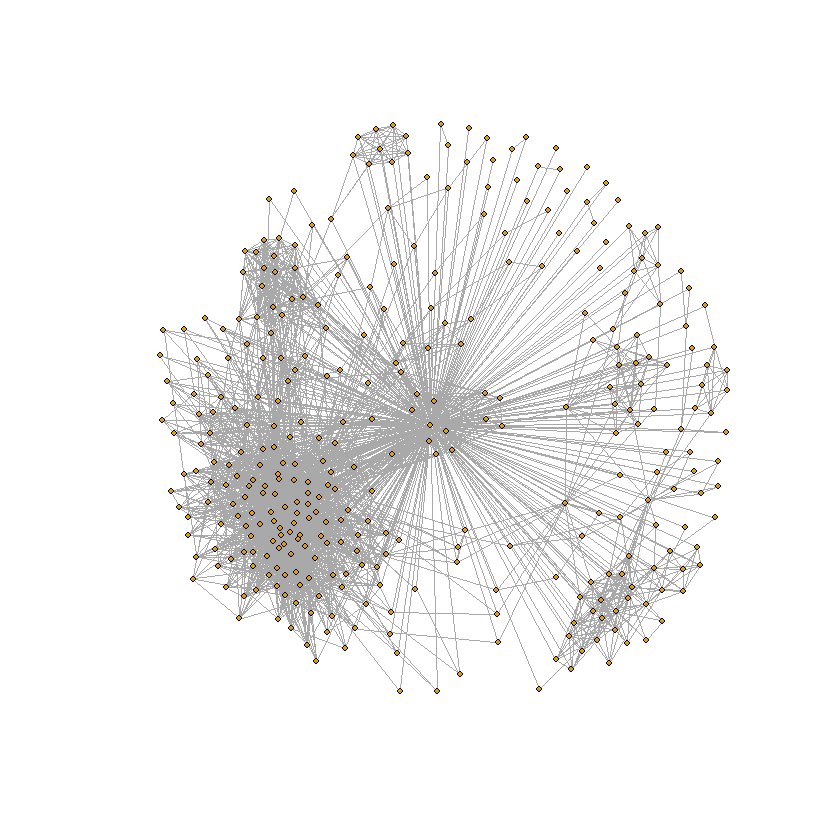

In [132]:
g1 = create_personalized_network(1, g)
plot(g1, vertex.label=V(g1)$vid, vertex.size=2,vertex.label.cex=0.1)

In [ ]:
# just a redo of 1.3.1 to see if this is faster. 

core_ids <- c(1,108,349,484,1087)
#graphs <- lapply(core_ids, create_personalized_network(g))
p_graphs <- lapply(core_ids, create_personalized_network, g)

fg <- lapply(p_graphs, cluster_fast_greedy)
eb <- lapply(p_graphs, cluster_edge_betweenness)
im <- lapply(p_graphs, cluster_infographs)

fg.mods <- lapply(fg, function(x) max(x$mod))
eb.mods <- lapply(eb, function(x) max(x$mod))
im.mods <- lapply(im, function(x) max(x$mod))

In [13]:
length(fg.mods)

[1] 5

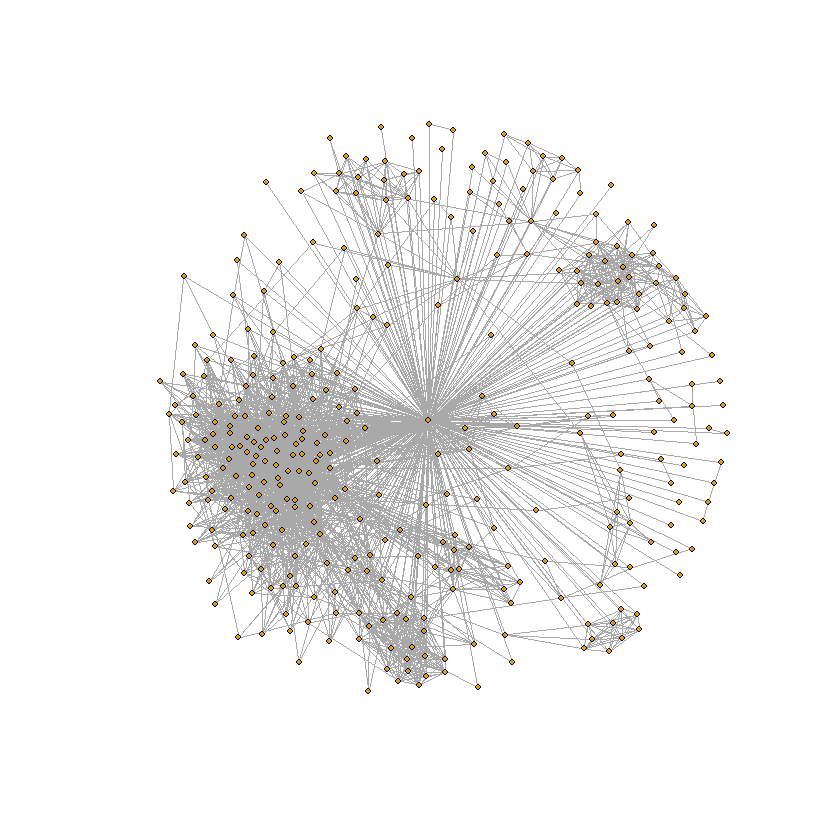

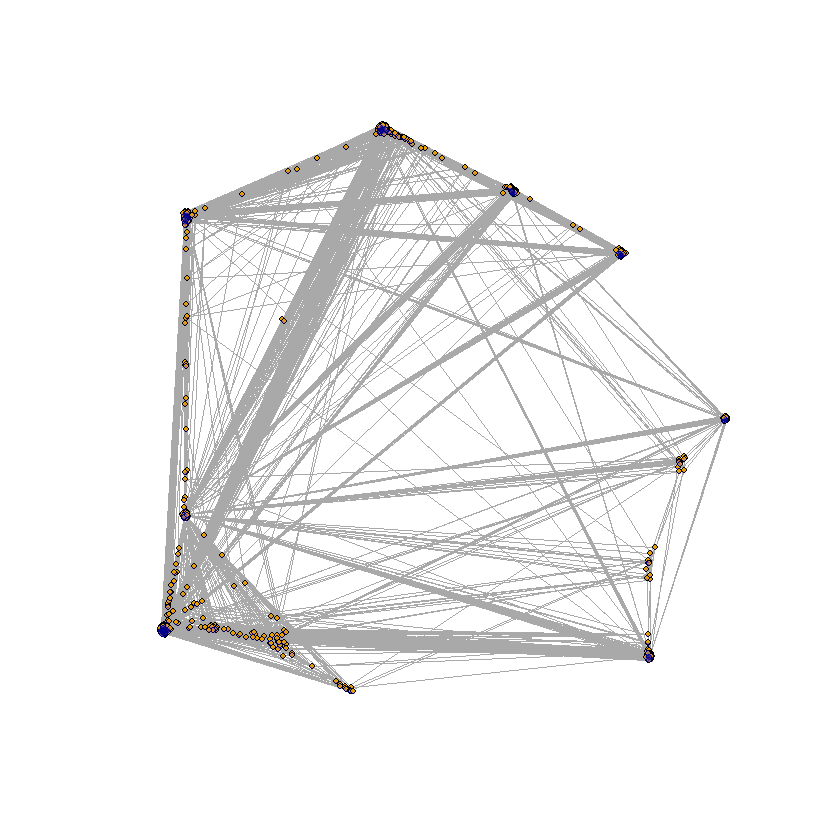

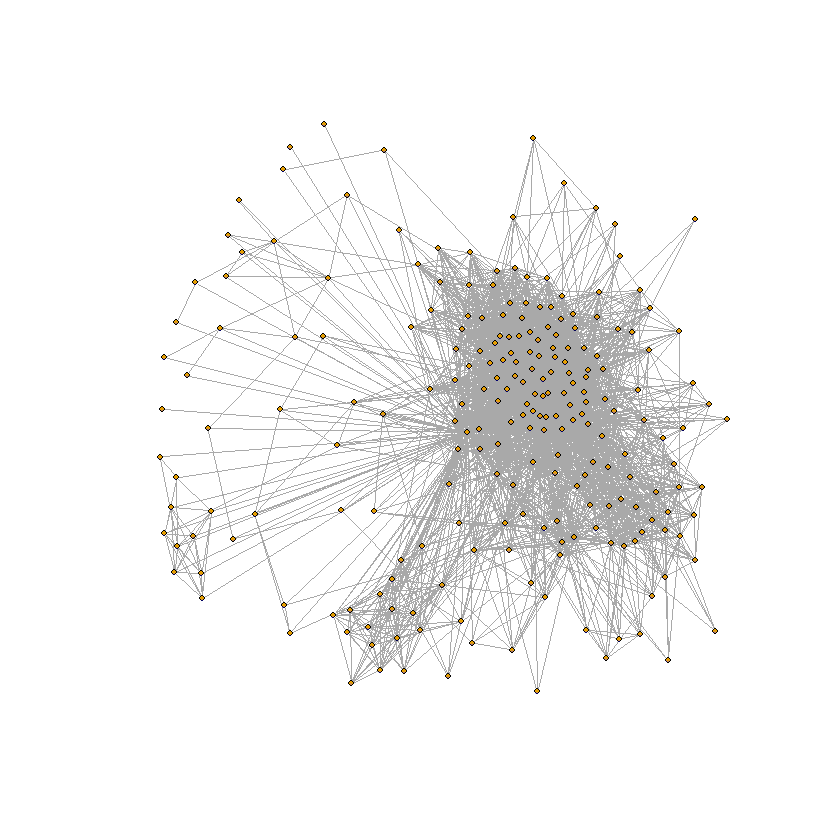

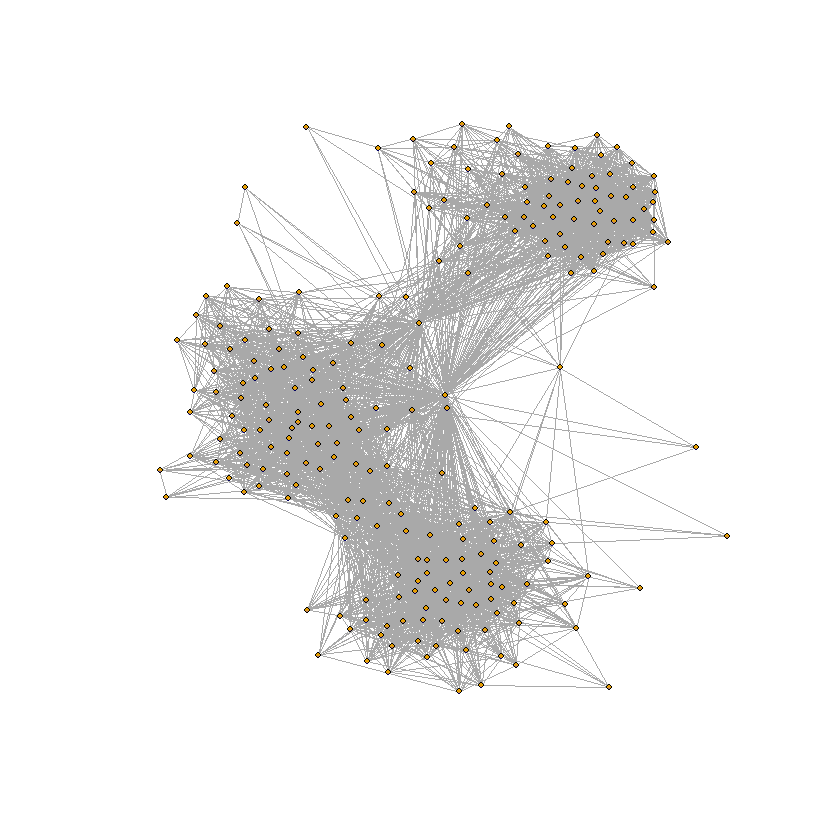

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

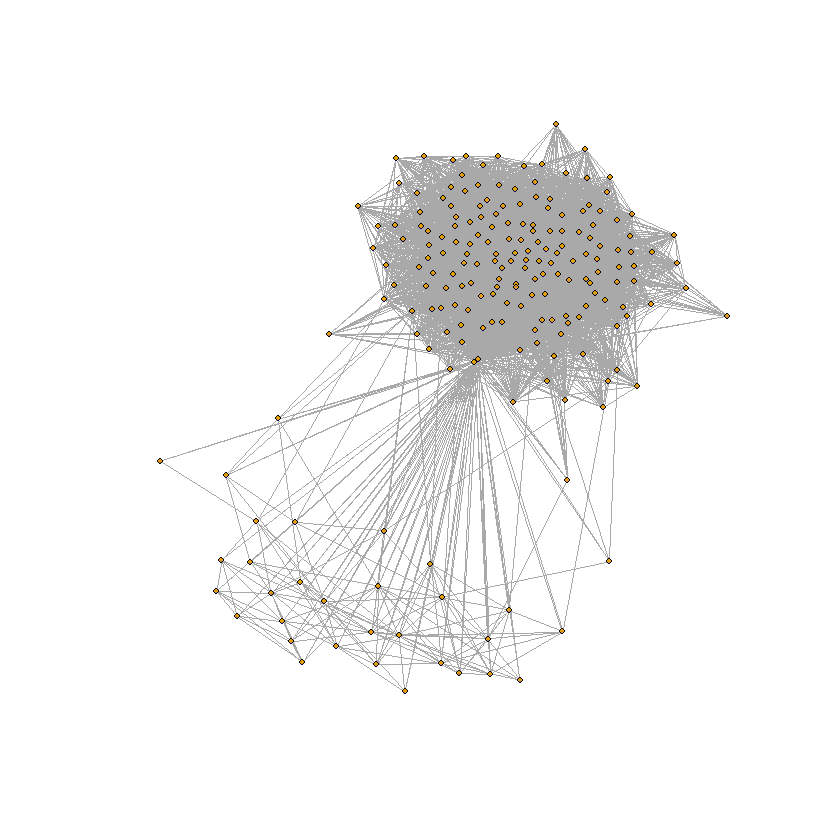

In [8]:
lapply(p_graphs, plot, vertex.size=2,vertex.label.cex=0.1)

In [108]:
core_ids=c(1) #,108,349,484,1087)
m <- seq(1,vcount(g))
m <- m[!(m %in% neighbors(g,n))] #not connected to n
g1 <- delete.vertices(g, m)
g1_embed <- degree(g1) # gets the embeddedness. 



In [ ]:
g1 = create_personalized_network(1, g, F)
g1_embed <- degree(g1)

for ( i in V(g1)$vid ) {
    g2 = create_personalized_network(i, g1, F) # find the mutual graph. 
    # continue: find the dispersion. 
}

    

1. Because of how these graphs are constructed, the number of mutual friends that a node has is the degree of that node in the personalized network without the core node. Since each of the nodes in this network is a friend of the core node, the number of connections in this graph is equal to the embeddedness. 

In [109]:
g1_embed

[1] 204  20   8  11  16  13  95  13 101  61 110  77  62  69  72  88  64  72
 [19]  42  99  54  95   2  64  38  10  48  32 113   8  35  44  98 123  86  10
 [37]  78  14  85  35  80  38  87 133  70  46 107  45   6  92  59 100  70  78
 [55]  16  76  84  27 107 110   9  61 142  37  56 115  70  81  14  96  72  90
 [73]  76  93  84  76   9  43  70  64  78   7  85  42  10  78  76  90  67  59
 [91]  48 138  13 106  85  46 110 114 133 113 122  50  76   6   7  11   8 142
[109]  10  89  61 100  46   9  73 119  56  61  94  74 110  23  95  53  91  23
[127]  92  62  11  67  36 129 103  80  97  92  60  74 122 122  77  87  74 125
[145] 113  54  70  59  58   7 100 144  91  94   4  70   5   7  50  83 130 126
[163]   7  93  77  30   6 130  75 105  59  71 138  87  48  28  95  75 121  82
[181] 103 151 136  82  70  85  92 122   6  34 136 101  69  11  88  52  75  82
[199]  42 111  76 162  67  84   4